##### <center><h1>Datos de generación de energía solar</h1></center>

#### Estos datos se han recopilado en una central solares de la India durante un periodo de 34 días. Hay un conjunto de datos de generación de energía y un conjunto de datos de lecturas de sensores. Los conjuntos de datos de generación de energía se recopilan a nivel de inversor: cada inversor tiene varias líneas de paneles solares conectadas a él. Los datos de los sensores se recopilan a nivel de planta: un único conjunto de sensores colocados de forma óptima en la planta.

#### Hay algunas áreas de preocupación en la planta de energía solar -

#### ¿Podemos predecir la generación de energía según la radiación? - esto permite una mejor gestión de la red
#### ¿Podemos identificar la necesidad de limpieza/mantenimiento de los paneles?
#### ¿Podemos identificar los equipos defectuosos o con un rendimiento inferior al óptimo?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
import datetime 
from sklearn.linear_model import LinearRegression
import scipy.stats
from scipy.stats import ranksums
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


## 1.Dataset

#### Se leen los archivos y se pasan a data frames para poder operar con ellos, contamos con dos archivos. Uno donde se representan la generación de energía por convertidor y fecha, y otro con la información de los sensores sobre la radiación y la temperatura correspondiente de cada día.

In [2]:
P1_Gen =pd.read_csv('Plant_1_Generation_Data.csv')
P2_Gen =pd.read_csv('Plant_2_Generation_Data.csv')
P1_wea=pd.read_csv('Plant_1_Weather_Sensor_Data.csv')
P2_wea=pd.read_csv('Plant_2_Weather_Sensor_Data.csv')


#### Se cambian las fechas a formato datetime.

In [3]:

P1_Gen['DATE_TIME'] = pd.to_datetime(P1_Gen['DATE_TIME'],format='%d-%m-%Y %H:%M')
P1_wea['DATE_TIME'] =pd.to_datetime(P1_wea['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')





#### Se unen los datasets de generación y de sensores por fecha y hora, mientras que se limpian ciertas columnas y a otras se les cambia el nombre para facilitar el operar con ellas.

In [4]:
P1= pd.merge(P1_Gen, P1_wea,on='DATE_TIME')
P1=P1.drop(columns=['PLANT_ID_x','PLANT_ID_y','SOURCE_KEY_y'])
P1.rename(columns={'SOURCE_KEY_x': 'INVERTER_ID'}, inplace=True)


P1['HORA']=P1['DATE_TIME'].dt.hour 
P1['DIA']=P1['DATE_TIME'].dt.day 

P1.head()


,DATE_TIME,INVERTER_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,HORA,DIA
0,2020-05-15,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0,0,15
1,2020-05-15,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0,0,15
2,2020-05-15,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0,0,15
3,2020-05-15,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0,0,15
4,2020-05-15,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0,0,15


##### DATE_TIME: Fecha en formato de fecha.
##### INVERTER_ID: Etiqueta del inversor.
##### DC_POWER: Potencia de corriente contínua recibida por el inversor (kW).
##### AC_POWER: Potencia de corriente alterna saliente del inversor (kW).
##### DAILY_YIELD: Energía total diaria acumulada por inversor (kWh).
##### TOTAL_YIELD: Energía total acumulada por inversor (kWh).
##### AMBIENT_TEMPERATURE: Temperatura ambiente para ese momento en específico.
##### MODULE_TEMPERATURE: Temperatura de las placas para ese momento en específico.
##### IRRADIATION: Radiación para ese momento en específico.
##### HORA: Hora en formato numérico
##### DIA: Día en formato numérico.


## 2.Visualización de los datos

Ploteamos todo a nivel temporal(5 dias)

In [5]:
P1_Gen_semana=P1[(P1['DIA']>=22)&(P1['DIA']<=28)]

#### 2.1 Se plotea el DAILY_YIELD durante una semana para intentar apreciar patrones en los datos.

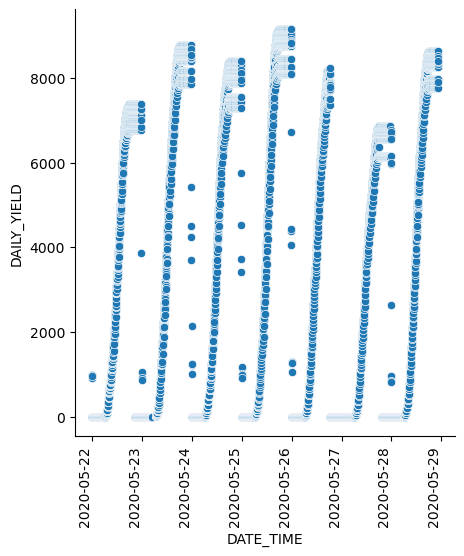

In [6]:

g1 = sns.relplot(x = "DATE_TIME", y = "DAILY_YIELD", data = P1_Gen_semana)
g1.set_xticklabels(rotation=90, ha='right')




#### Para poder diferenciar un poco mejor los inversores y obtener mas información se procede a colorear por inversores.

<Figure size 4000x2000 with 0 Axes>

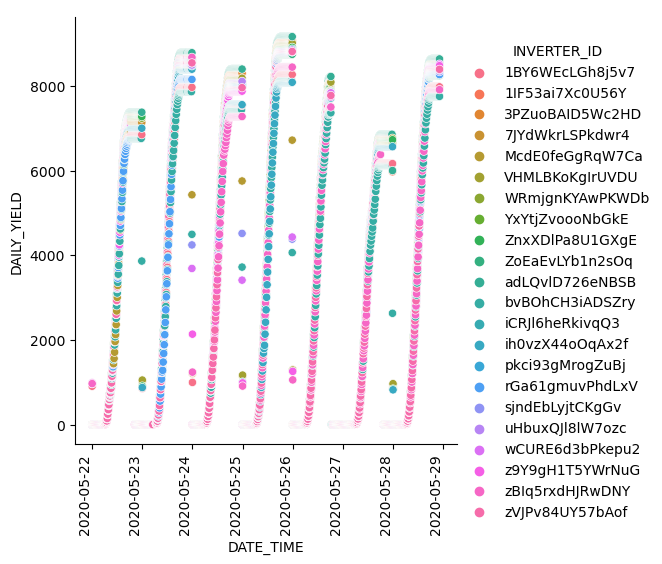

In [7]:
plt.figure(figsize=(40, 20)) 
g1 = sns.relplot(x = "DATE_TIME", y = "DAILY_YIELD", data = P1_Gen_semana, hue = P1_Gen_semana.INVERTER_ID)
g1.set_xticklabels(rotation=90, ha='right')


#### El nuevo gráfico no es demasiado indicativo, pero se pueden sacar varias conclusiones. La primera es que el DAILY_YIELD sigue un claro patrón diario, esto tiene sentido ya que cada día la acumulacíon de energía será proporcional al ciclo del sol. La segunda es que hay una diferencia clara de cuanto acumula cada inversor, lo que no sabemos es si son los mismos inversores los que están en la parte baja del DAILY_YIELD todos los días. Y por último, en el gráfico se puede apreciar como hay ciertos valores que consideraríamos outliers, al ser un gráfico de medias, los valores nulos y los ceros habrán afectado en el cálculo.

#### 2.2 Por tanto, se buscará que datos faltan en nuestro dataset, para valorar si los datos son buenos y nos sirven.

In [8]:
# Crear una lista de todas las fechas que deberían estar presentes en tus datos
rango_tiempo = pd.date_range(start=P1['DATE_TIME'].min(), end=P1['DATE_TIME'].max(), freq='15min')
fechas_esperadas = rango_tiempo.strftime('%Y-%m-%d %H:%M:%S').tolist()

# Crear una lista de las fechas que realmente están presentes en tus datos
fechas_reales = P1['DATE_TIME'].dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
# Encontrar las fechas que faltan
fechas_faltantes = list(set(fechas_esperadas) - set(fechas_reales))

# Imprimir las fechas que faltan
if len(fechas_faltantes) > 0:
    print('Faltan ' + str(len(fechas_faltantes))+' registros en los datos')
    print(fechas_faltantes)
   
else:
    print('No faltan registros en los datos')



Faltan 107 registros en los datos
['2020-05-29 02:15:00', '2020-05-20 16:45:00', '2020-05-16 01:00:00', '2020-06-03 14:00:00', '2020-05-16 00:15:00', '2020-05-21 01:15:00', '2020-05-20 15:30:00', '2020-05-23 21:45:00', '2020-05-20 14:45:00', '2020-05-29 00:00:00', '2020-05-21 03:30:00', '2020-05-29 04:30:00', '2020-05-29 02:00:00', '2020-05-21 06:45:00', '2020-05-20 13:30:00', '2020-05-29 02:30:00', '2020-05-21 01:45:00', '2020-05-21 00:30:00', '2020-05-29 01:30:00', '2020-05-29 03:15:00', '2020-05-29 01:15:00', '2020-05-21 05:15:00', '2020-05-19 12:00:00', '2020-05-28 23:00:00', '2020-05-21 05:00:00', '2020-05-29 03:30:00', '2020-05-21 04:00:00', '2020-05-20 15:00:00', '2020-05-19 12:15:00', '2020-05-29 05:15:00', '2020-05-20 15:45:00', '2020-05-21 00:00:00', '2020-05-21 07:00:00', '2020-05-21 07:30:00', '2020-05-21 05:30:00', '2020-05-23 06:00:00', '2020-05-20 13:45:00', '2020-05-21 03:45:00', '2020-05-21 06:30:00', '2020-05-29 05:30:00', '2020-05-20 17:00:00', '2020-05-23 06:30:00',

In [9]:
fechas_faltantes = list(set(fechas_esperadas) - set(fechas_reales))
fechas_faltantes=pd.DataFrame(fechas_faltantes,columns=['DATE_TIME'])
fechas_faltantes['DATE_TIME'] = pd.to_datetime(fechas_faltantes['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
fechas_faltantes['DATE_TIME']=fechas_faltantes['DATE_TIME'].dt.date
print('Faltan registros desde ' + str(fechas_faltantes['DATE_TIME'].min())+' hasta '+str(fechas_faltantes['DATE_TIME'].max()))
fechas_faltantes=fechas_faltantes.value_counts().reset_index().sort_values('DATE_TIME')
fechas_faltantes=fechas_faltantes.rename(columns={'count':'Horas'})
fechas_faltantes['Horas']=(fechas_faltantes['Horas']*15)/60
print('Hay ' + str(fechas_faltantes['Horas'].sum()) +' horas de datos faltantes')

Faltan registros desde 2020-05-15 hasta 2020-06-17
Hay 26.75 horas de datos faltantes


#### Se hace un plot de las horas que faltan por día.

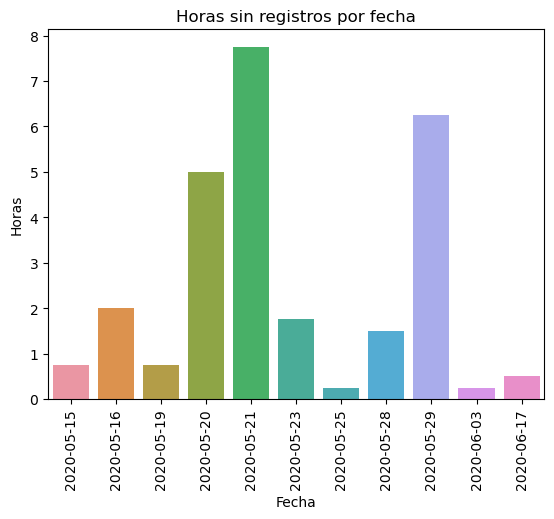

In [10]:

sns.barplot(x=fechas_faltantes['DATE_TIME'], y=fechas_faltantes['Horas'])
plt.xlabel('Fecha')
plt.ylabel('Horas')
plt.title('Horas sin registros por fecha')
plt.xticks(rotation=90)
plt.show()
plt.show()

#### Podemos apreciar que faltan entradas de datos en ciertas horas. Algunos son muy bajas pero por ejemplo para el 21 faltan 8 horas. Puede deberse  a que la planta haya estado cerrada o de mantenimiento durante cierto tiempo.

## 3.Análisis de patrones en las variables.

### 3.1 Se analiza el patrón diario.

#### Primero se plotea un una mediana de los valores obtenidos por hora.

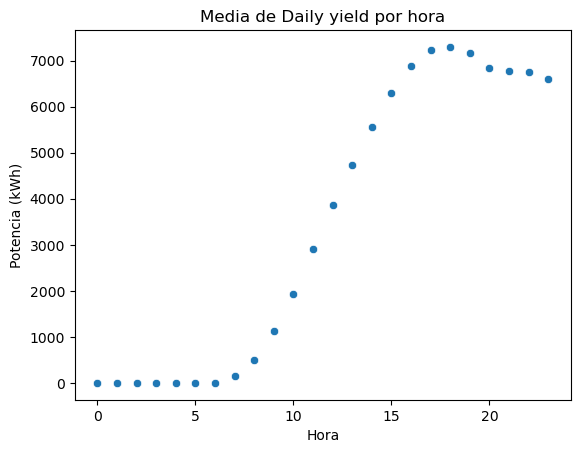

In [11]:
# Group the data by hour and calculate the mean of AC and DC for each hour

hourly_means = P1.groupby('HORA')[['DAILY_YIELD']].median().reset_index()



# Plot the mean AC and DC power for each hour
sns.scatterplot(data=hourly_means, x='HORA', y='DAILY_YIELD')

# Set the plot title and axis labels
plt.title('Media de Daily yield por hora')
plt.xlabel('Hora')
plt.ylabel('Potencia (kWh)')

# Show the plot
plt.show()

#### Se puede apreciar un descenso al final del día lo cual no tiene mucho sentido, ya que la energía acumulada no debería de disminuir. La curva no satura a un valor constante por la falta de registros al final del dia de ciertos inversores. Para apreciar mejor las tendencias se hace un plot de todos los datos de un día aletorio.

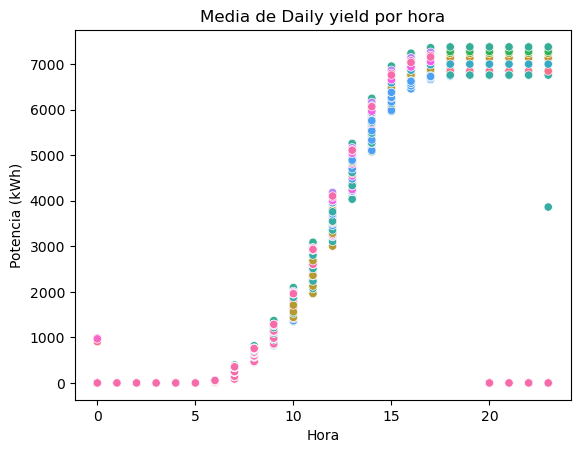

In [12]:
# Group the data by hour and calculate the mean of AC and DC for each hour
P1_day = P1[P1['DIA']== 22]


# Plot the mean AC and DC power for each hour
sns.scatterplot(data=P1_day, x='HORA', y='DAILY_YIELD', hue = 'INVERTER_ID')

# Set the plot title and axis labels
plt.title('Media de Daily yield por hora')
plt.xlabel('Hora')
plt.ylabel('Potencia (kWh)')
plt.legend().remove()
# Show the plot
plt.show()

#### Podemos ver como al principio del dia(radiación baja) el total de energía generada es 0 y al final de día(radiación baja) satura a un valor. También se ve como faltan algunos datos o son 0 en algunos inversores, por eso salen outliers el gráfico anterior.

#### Hacemos el mismo procedimiento para DC y AC

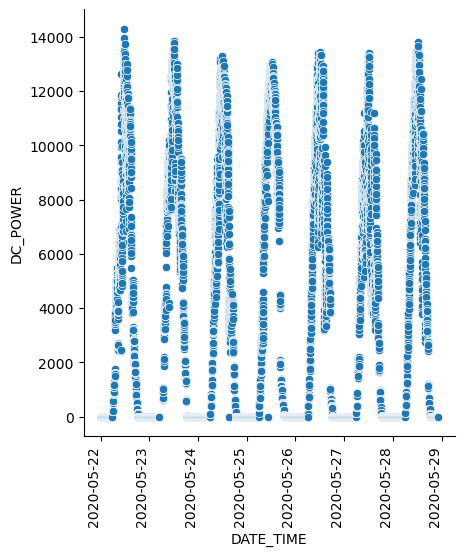

In [13]:

g1 = sns.relplot(x = "DATE_TIME", y = "DC_POWER", data = P1_Gen_semana)
g1.set_xticklabels(rotation=90, ha='right')


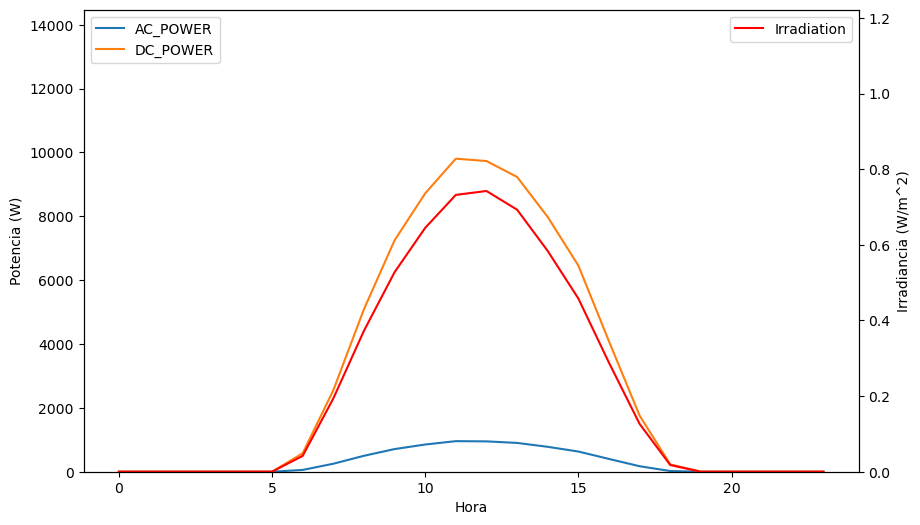

In [14]:
hourly_means = P1.groupby('HORA')[['AC_POWER', 'DC_POWER','IRRADIATION']].mean().reset_index()
hourly_means= hourly_means.melt(id_vars=["HORA"], var_name="variable", value_name="value")

# Crear una figura y dos ejes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Graficar los valores de "AC_POWER" y "DC_POWER" con respecto a "HORA" en el primer eje,
# y los valores de "IRRADIATION" con respecto a "HORA" en el segundo eje
sns.lineplot(data=hourly_means[hourly_means["variable"].isin(["AC_POWER", "DC_POWER"])], x="HORA", y="value", hue="variable", ax=ax1)
sns.lineplot(data=hourly_means[hourly_means["variable"] == "IRRADIATION"], x="HORA", y="value", color="red", ax=ax2,label="Irradiation")

# Configurar los ejes para que tengan diferentes escalas y etiquetas
ax1.set_ylabel("Potencia (W)")
ax2.set_ylabel("Irradiancia (W/m^2)")
ax1.set_xlabel("Hora")
ax1.set_ylim(0, P1.DC_POWER.max())
ax2.set_ylim(0, P1.IRRADIATION.max())
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

#### Se puede apreciar como en las horas en las que no hay sol no se produce energía y en las horas de máximo sol obtenemos la máxima producción. Y además podemos ver que la diferencia de ac a dc es muy grande, esto podría deberse a la eficiencia de los inversores que estudiaremos posteriormente.

#### Para analizar los datos correctamente, calculamos la matriz de correlaciones, para así ver la relación lineal real entre variables.

##### Con respecto a DC_POWER:

In [15]:
numeric_columns = P1.select_dtypes(include=[np.number])
corr_matrix = numeric_columns.corr()
# Show correlations with the variable we want to predict, "median_house_value"
corr_matrix["DC_POWER"].sort_values(ascending=False)

DC_POWER               1.000000
AC_POWER               0.999996
IRRADIATION            0.989391
MODULE_TEMPERATURE     0.954811
AMBIENT_TEMPERATURE    0.724668
DAILY_YIELD            0.082243
DIA                    0.033072
HORA                   0.024083
TOTAL_YIELD            0.003851
Name: DC_POWER, dtype: float64

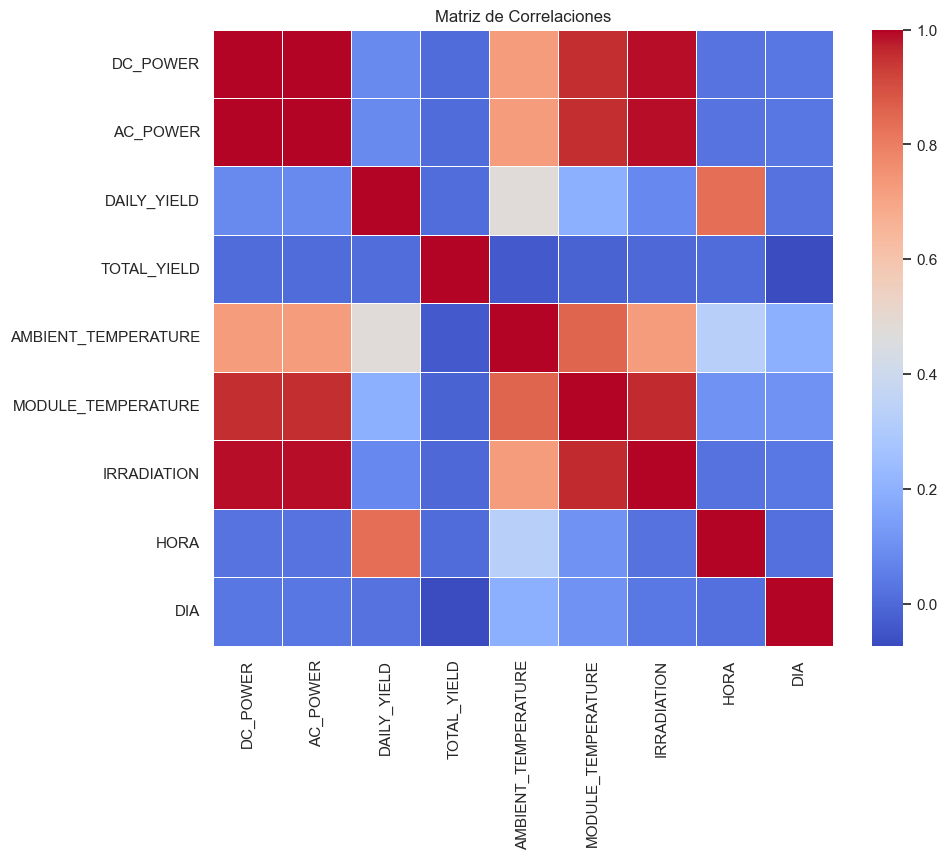

In [16]:
sns.set(style="white")
plt.figure(figsize=(10, 8))

# Crea el plot de la matriz de correlaciones
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)

plt.title("Matriz de Correlaciones")
plt.show()

#### Podemos apreciar una relación directa entre AC, DC y la radiación, junto a las temperaturas.

##### Con respecto a AC_POWER:

In [17]:
numeric_columns = P1.select_dtypes(include=[np.number])
corr_matrix = numeric_columns.corr()
# Show correlations with the variable we want to predict, "median_house_value"
corr_matrix["AC_POWER"].sort_values(ascending=False)

AC_POWER               1.000000
DC_POWER               0.999996
IRRADIATION            0.989340
MODULE_TEMPERATURE     0.954924
AMBIENT_TEMPERATURE    0.724903
DAILY_YIELD            0.082193
DIA                    0.032997
HORA                   0.024080
TOTAL_YIELD            0.003840
Name: AC_POWER, dtype: float64

#### Es importante matizar que aqui estamos viendo las correlaciones lineales entre variables. La hora tiene una correlación no lineal y por eso se muestra una correlación tan baja.

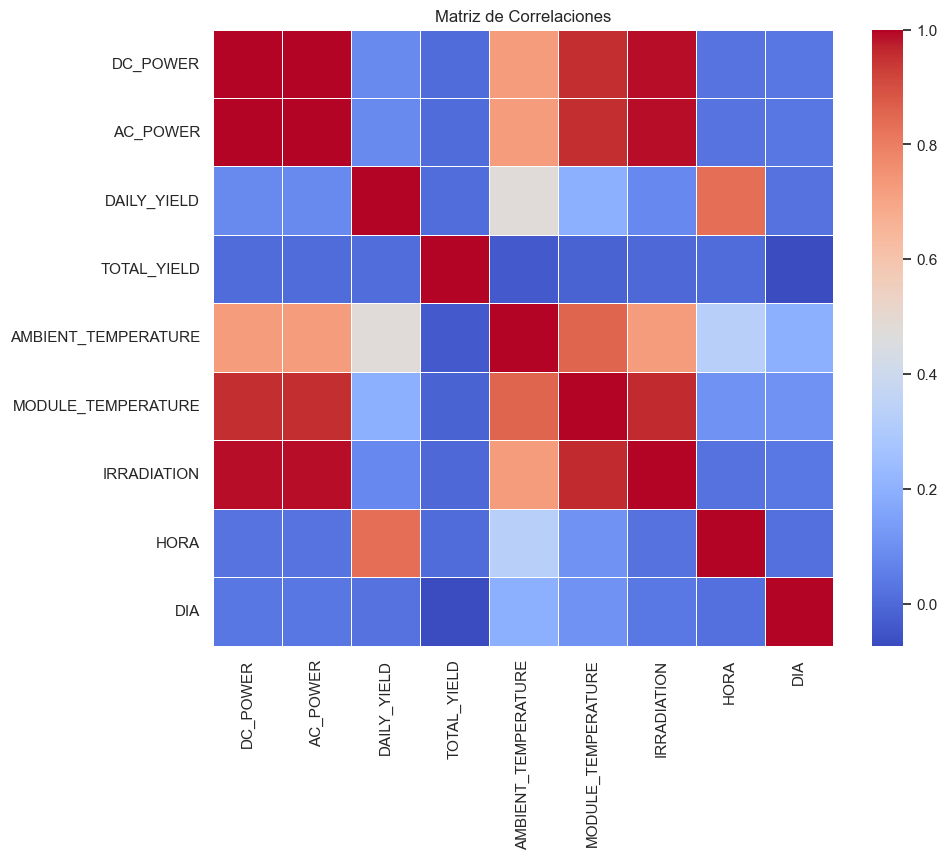

In [18]:
sns.set(style="white")
plt.figure(figsize=(10, 8))

# Crea el plot de la matriz de correlaciones
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)

plt.title("Matriz de Correlaciones")
plt.show()

### 3.2 Análisis de transformación de energía por inversor.

#### Hacemos un clustering de la media de la radiacion recibida por inversor para ver si los datos se agrupan por si solos de forma natural. Para ello utilizamos k-means para calcular el numero óptimo de clusters que queremnos.

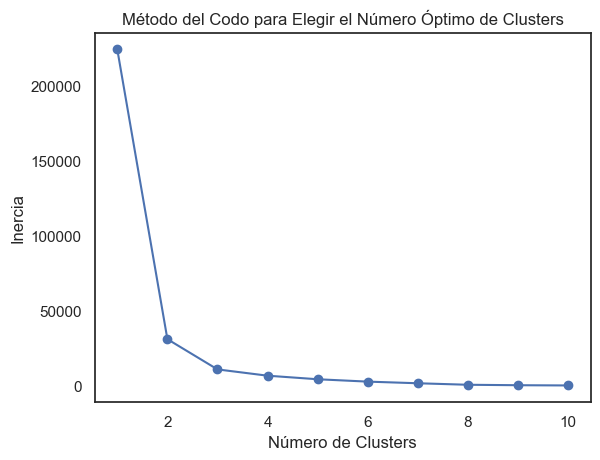

In [19]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Carga tus datos de radiación en un DataFrame de pandas
# Supongamos que tienes un DataFrame llamado 'data' con una columna 'radiacion'

# Selecciona la columna de radiación para el clustering
radiation_means = P1.groupby('INVERTER_ID')['DC_POWER'].mean().reset_index()
radiation_means = radiation_means.drop('INVERTER_ID', axis = 1)
# Lista para almacenar valores de inercia
inercia = []

# Rango de número de clusters que deseas probar
rango_clusters = range(1, 11)  # Prueba desde 1 hasta 10 clusters

# Calcula la inercia para diferentes valores de clusters
for k in rango_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(radiation_means)
    inercia.append(kmeans.inertia_)

# Plotea la inercia en función del número de clusters
plt.plot(rango_clusters, inercia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo para Elegir el Número Óptimo de Clusters')
plt.show()

#### Hacemos plot de los clusters para ver patrones naturales en los datos.

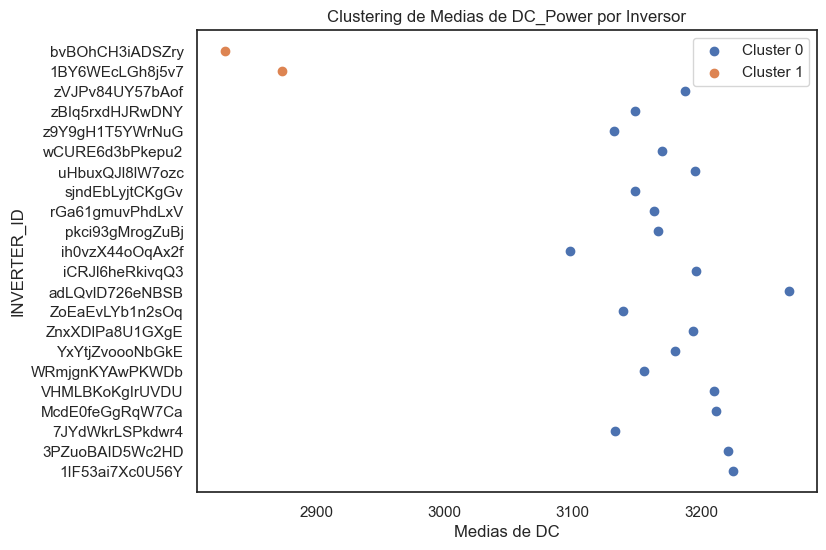

In [20]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado 'data' con las columnas 'INVERTER_ID' y 'IRRADIATION'
# y deseas calcular las medias de radiación por inversor.

# 1. Calcular las medias de radiación por inversor
radiation_means = P1.groupby('INVERTER_ID')['DC_POWER'].mean().reset_index()

# 2. Aplicar el algoritmo de clustering (K-Means) a las medias de radiación
k = 2  # Puedes ajustar el número de clústeres según tus necesidades
kmeans = KMeans(n_clusters=k, random_state=0)
radiation_means["cluster"] = kmeans.fit_predict(radiation_means[['DC_POWER']])

# Visualizar los resultados del clustering
plt.figure(figsize=(8, 6))
for cluster_id in range(k):
    cluster_data = radiation_means[radiation_means["cluster"] == cluster_id]
    plt.scatter(cluster_data['DC_POWER'], cluster_data['INVERTER_ID'], label=f"Cluster {cluster_id}")

plt.xlabel("Medias de DC")
plt.ylabel("INVERTER_ID")
plt.title("Clustering de Medias de DC_Power por Inversor")
plt.legend()
plt.show()

#### Podemos apreciar que claramente hay dos inversores que reciben menos DC de media. Esto podría deberse a que tienen menos paneles, que les da la sombra o que fallan los paneles, no tiene por que deberse a los inversores en si.

#### Se procede a analizar la distribución de las variables.

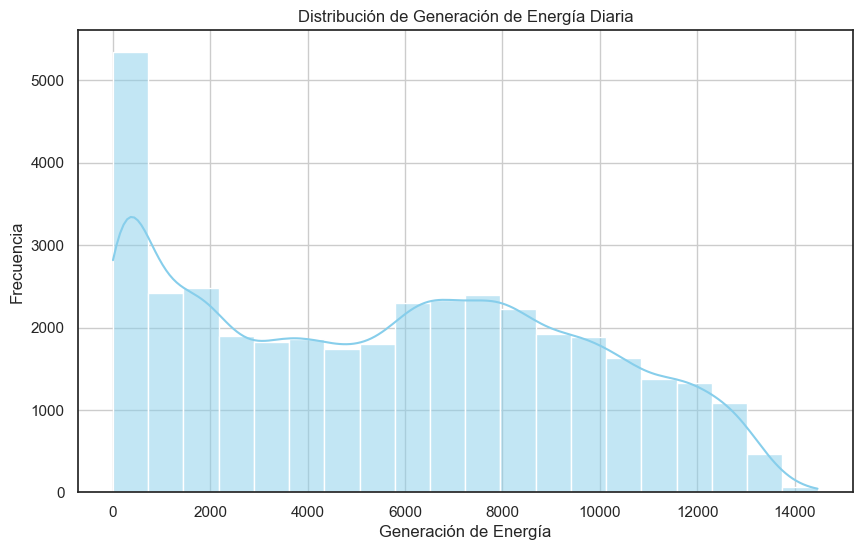

In [21]:
# Agrupa los datos por día y suma la generación diaria
P1_mod=P1[P1.IRRADIATION>0]
#daily_generation = P1.groupby(P1['DATE_TIME'].dt.date)['DC_POWER'].sum().reset_index()

# Crea el histograma con Seaborn
plt.figure(figsize=(10, 6))
#sns.histplot(data=daily_generation, x='DC_POWER', bins=20, kde=True, color='skyblue')
sns.histplot(data=P1_mod, x='DC_POWER', bins=20, kde=True, color='skyblue')
plt.title('Distribución de Generación de Energía Diaria')
plt.xlabel('Generación de Energía')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.show()

#### Como no tiene una distribución normal se tendrán que usar métodos no paramétricos.

#### Vamos hacer boxplots para visualizar mejor las diferencias, y posteriormente aplicaremos los Willcoxon test pareado para ver si hay diferencias significativas entre inversores.

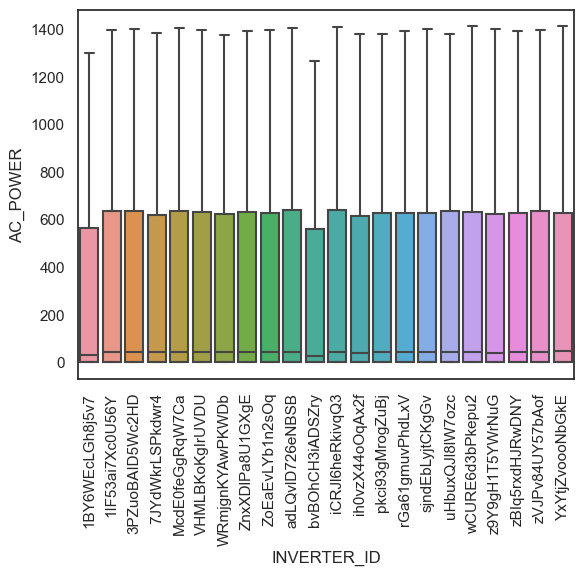

In [22]:
g1=sns.boxplot(x='INVERTER_ID', y='AC_POWER', data=P1)
plt.xticks(rotation=90)
plt.show()


#### Aplicamos un wilcoxon test entre todos los inversores para apreciar diferencias estadísticamente significativas entre ellos, ya que al no ser una distribucion normal, no podemos aplicar el t-test.

In [23]:
inversores=P1.INVERTER_ID.unique()

for i in inversores:
    x = P1.loc[P1.INVERTER_ID == i].AC_POWER.values
    y = P1.loc[P1.INVERTER_ID != i].AC_POWER.values
    _,pv = ranksums(x, y, alternative='less')
      
    if pv < 0.05:
        print(i + 'is signficantly worse than the rest of inverters: ' + str(pv))
        


1BY6WEcLGh8j5v7is signficantly worse than the rest of inverters: 0.00436590293858956
bvBOhCH3iADSZryis signficantly worse than the rest of inverters: 0.0012820558813648661


#### Al ver el boxplot anterior, no hemos dado cuenta de que todos están muy cerca del cero, esto se debe a que durante los tramos de día que no hay sol, el valor de la radiación es 0, por tanto mas de la mitad de nuestros datos son nulos. Esto afectará tanto a la media como a la mediana de todos los inversores proporcionalmente, pero reducirá mucho la visivilidad del efecto, es decir, las diferencias estadísticamente significativas entre grupos.

#### Gráficamos sin ceros y volvemos a hacer los Willcoxon tests.

##### Respecto a AC_POWER:

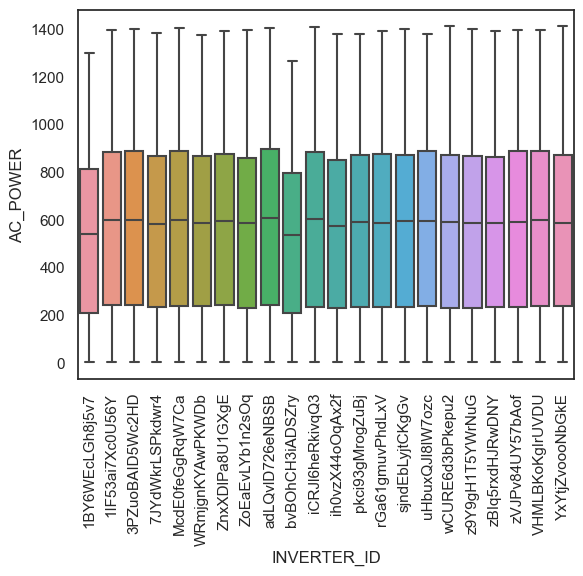

In [24]:
P1_mod = P1.drop(P1[P1.AC_POWER == 0].index)
sns.boxplot(x='INVERTER_ID', y='AC_POWER', data=P1_mod)
plt.xticks(rotation=90)
plt.show()


##### Respecto a DC_POWER:

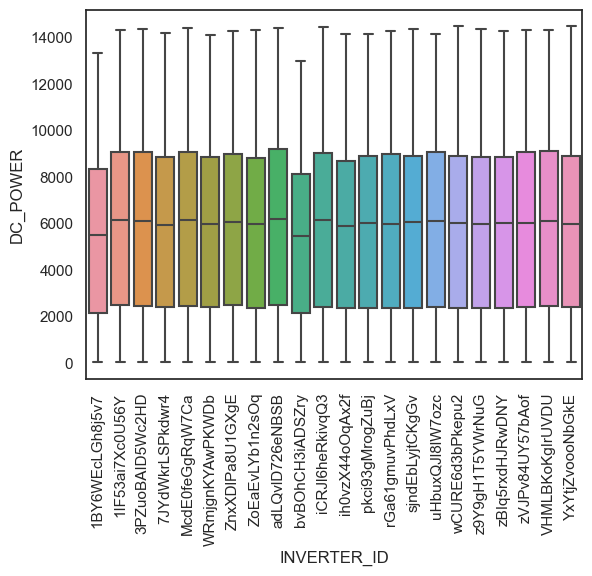

In [25]:
g1=sns.boxplot(x='INVERTER_ID', y='DC_POWER', data=P1_mod )
plt.xticks(rotation=90)
plt.show()

##### Respecto al DAILY_YIELD:

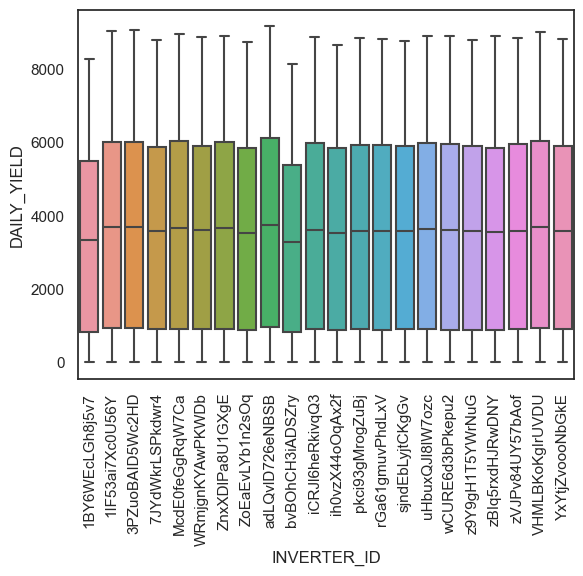

In [26]:

sns.boxplot(x='INVERTER_ID', y='DAILY_YIELD', data=P1_mod )
plt.xticks(rotation=90)
plt.show()



#### Directamente se puede apreciar que las diferencias entre grupos son más visibles ahora que no hay ceros. Además, estos fallos serán por las placas conectadas al inversor, no porque el inversor sea menos eficiente que los demás. Y esto lo sabemos porque tienen una entrada de DC más baja, de media.

##### Volvemos a hacer un wilcoxon test para comparar si el quitar los ceros del dataset ha afectado a los p-values

In [46]:
inversores_peores = []
for i in inversores:
    x = P1_mod.loc[P1_mod.INVERTER_ID == i].DC_POWER.values
    y = P1_mod.loc[P1_mod.INVERTER_ID != i].DC_POWER.values
    _,pv = ranksums(x, y, alternative='less')
      
    if pv < 0.05:
        print(i + 'es significativamente peor que el resto de inversores: ' + str(pv))
        inversores_peores.append(i)


1BY6WEcLGh8j5v7es significativamente peor que el resto de inversores: 7.307927028993386e-06
bvBOhCH3iADSZryes significativamente peor que el resto de inversores: 1.332133085592398e-07


##### El resultado del los tests es exactamente el mismo. Son los mismos dos inversores los que dan menos ac_power y dc_power. Sin embargo, los p_values son muchísimo más significativos

#### Dibujamos las curvas de los dos inversores que producen menos respecto al resto

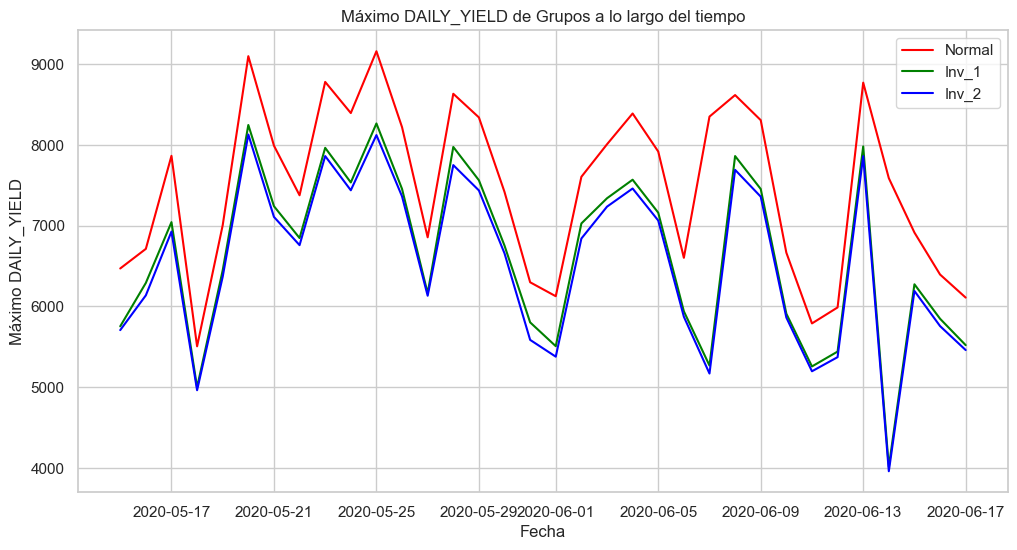

In [47]:
P1_pr1=P1[P1.INVERTER_ID== inversores_peores[0]]
P1_pr2=P1[P1.INVERTER_ID== inversores_peores[1]]
max_daily_yield = P1.groupby(P1['DATE_TIME'].dt.date)['DAILY_YIELD'].max().reset_index()
max_daily_yield_inv1=P1_pr1.groupby(P1_pr1['DATE_TIME'].dt.date)['DAILY_YIELD'].max().reset_index()
max_daily_yield_inv2=P1_pr2.groupby(P1_pr2['DATE_TIME'].dt.date)['DAILY_YIELD'].max().reset_index()

merged_df = pd.merge(max_daily_yield, max_daily_yield_inv1, on='DATE_TIME')
merged_df = pd.merge(merged_df, max_daily_yield_inv2, on='DATE_TIME')

# Calcula el valor medio de los máximos de generación diaria
valor_medio_maximo_generacion = max_daily_yield['DAILY_YIELD'].mean()



for inv in inversores_peores:
     P1_pr=P1[P1.INVERTER_ID== inv]
     max_daily_yield = P1_pr.groupby(P1_pr['DATE_TIME'].dt.date)['DAILY_YIELD'].max().reset_index()
     valor_medio_maximo_generacion = max_daily_yield['DAILY_YIELD'].mean()
     valor_maximo_generacion=max_daily_yield['DAILY_YIELD'].max()
    
# Configura el estilo de Seaborn
sns.set(style="whitegrid")

# Crea el gráfico de líneas con Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='DATE_TIME', y='DAILY_YIELD_x', data=merged_df, label='Normal', color='red')
sns.lineplot(x='DATE_TIME', y='DAILY_YIELD_y', data=merged_df, label='Inv_1', color='green')
sns.lineplot(x='DATE_TIME', y='DAILY_YIELD', data=merged_df, label='Inv_2', color='blue')

plt.title('Máximo DAILY_YIELD de Grupos a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Máximo DAILY_YIELD')
plt.legend()
plt.grid(True)

plt.show()

#### Se puede apreciar que en ningun día superan el daily yield los inversores defectuosos a los normales

### 3.3 Análisis de la eficiencia de cada inversor.

##### Ahora que sabemos que dos transforman menos energía, queremos ver si se debe a su propia eficiencia o a los paneles a los que estan conectados.

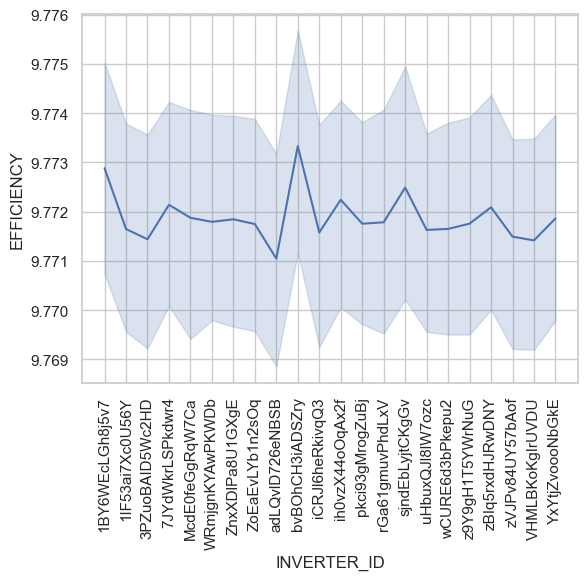

In [29]:
P1_mod['EFFICIENCY']=(P1_mod['AC_POWER']/P1_mod['DC_POWER'])*100
efficiency_means = P1_mod.groupby('INVERTER_ID')['EFFICIENCY'].mean().reset_index()
sns.lineplot(data=P1_mod, x="INVERTER_ID", y="EFFICIENCY")
plt.xticks(rotation=90)
plt.show()

#### Se puede apreciar que las eficiencias son muy parecidas y por tanto concluimos que o los paneles van mal, o simplemente reciben menos irradiación que los demás.

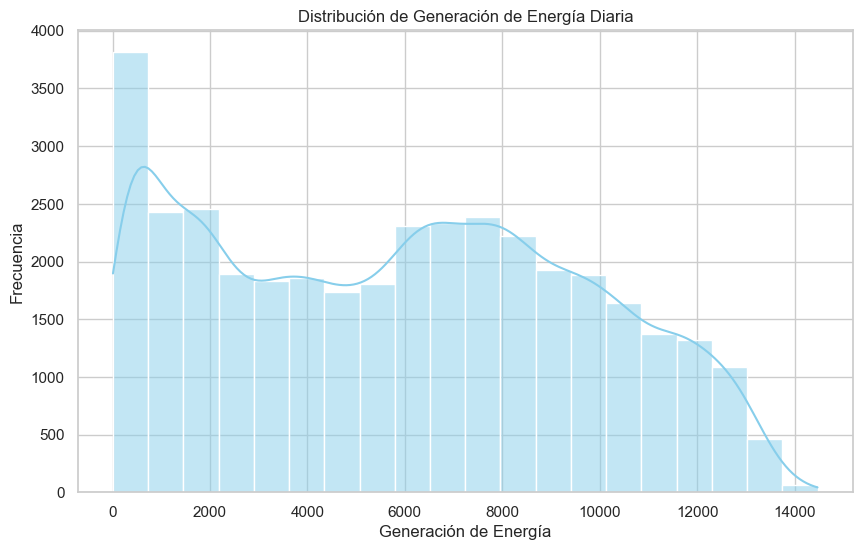

In [30]:


# Crea el histograma con Seaborn
plt.figure(figsize=(10, 6))
#sns.histplot(data=daily_generation, x='DC_POWER', bins=20, kde=True, color='skyblue')
sns.histplot(data=P1_mod, x='DC_POWER', bins=20, kde=True, color='skyblue')
plt.title('Distribución de Generación de Energía Diaria')
plt.xlabel('Generación de Energía')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.show()

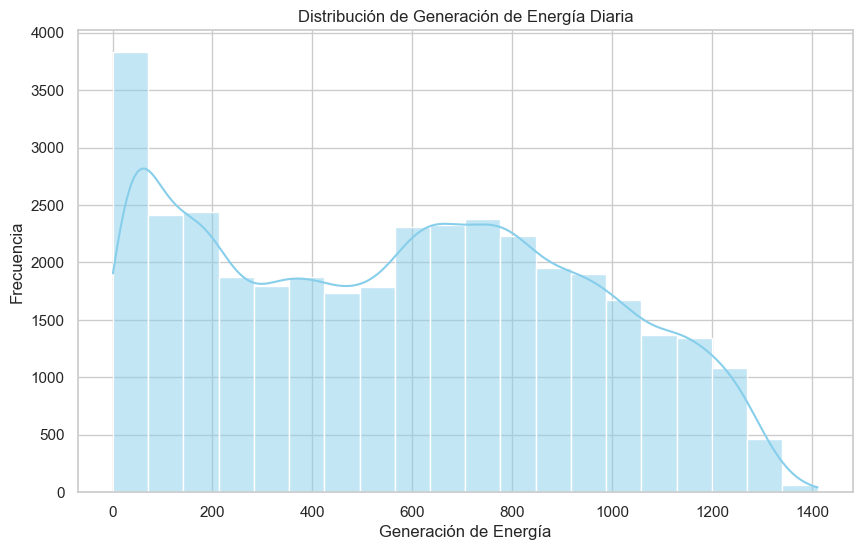

In [31]:
#daily_generation = P1.groupby(P1['DATE_TIME'].dt.date)['AC_POWER'].sum().reset_index()

# Crea el histograma con Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=P1_mod, x='AC_POWER', bins=20, kde=True, color='skyblue')
plt.title('Distribución de Generación de Energía Diaria')
plt.xlabel('Generación de Energía')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.show()

#### Como podemos ver, aunque ac y dc sean proporcionales, no siguen una distribucion normal, por tanto tenemos que usar metodos no paramétricos.


In [32]:
from scipy.stats import kruskal

# Get the efficiency values for each inverter
efficiencies = list()
for i in inversores:
    x = P1_mod.loc[P1_mod.INVERTER_ID == i].EFFICIENCY.values
    efficiencies.append(x)
f_value, p_value = kruskal(*efficiencies)

if p_value < 0.05:
    print("Hay diferencia entre las eficiencias de los inversores (p-value = {:.4f})".format(p_value))
else:
    print("No Hay diferencia entre las eficiencias de los inversores (p-value = {:.4f})".format(p_value))

No Hay diferencia entre las eficiencias de los inversores (p-value = 0.3004)


#### Podemos apreciar tanto visualmente como matematicamente que la diferencia de eficiencia de inversores es practicamente nula. Por tanto la conclusión es que el error se encuentra en los paneles conectados a  los inversores 1BY6WEcLGh8j5v7es y bvBOhCH3iADSZryes no a los inversores en si.

### 5.Modelo de machine learning para predecir la producción de energía

#### Ridge con cross validation para la radiación

#### Se ha realizar un modelo lineal para predecir la potencia en continua que producirá cada conjunto de placas fotovoltaica unidas a cada inversor. Se han escogidos las 3 features con mas correlación con DC para hacer el modelo. Se ha regularizado el modelo mediante ridge regression y se escogido el hiperparámetro por crossvalidation.

In [33]:
from sklearn.metrics import mean_absolute_error
# Dividir los datos en conjuntos de entrenamiento y prueba
X = P1[['IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE']]
y = P1[['AC_POWER']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
#Escalar los datos de entrenamiento y prueba
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear un modelo de Ridge Regression y ajustarlo a los datos de entrenamiento utilizando cross-validation
ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10], cv=10)
ridge.fit(X_train_scaled, y_train)

# Realizar predicciones en los datos de prueba
y_pred = ridge.predict(X_test_scaled )

# Evaluar el modelo utilizando el error cuadrático medio (MSE) y el coeficiente de determinación (R^2)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('El intercepto es '+str(ridge.intercept_)+'y  Los coeficientes son: '+str(ridge.coef_))
print('El alpha escogida es :'+str(ridge.alpha_))
print('El error Absoluto Medio (KW):', mae)
print('R^2:', r2)


El intercepto es [308.49869997]y  Los coeficientes son: [[371.35798073  20.35681566  -0.72829363]]
El alpha escogida es :0.001
El error Absoluto Medio (KW): 26.273893389193155
R^2: 0.97601029150585


#### Se puede observar una varianza explicada muy cercana a 1 y un error absoluto de 25kw

#### PCA y Feature Selection

#### Se ha realizado una PCA para visualizar una features del tiempo atmosférico en dos dimensiones

In [34]:
from sklearn.decomposition import PCA
X = P1[['IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE']]
pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X) #regular PCA



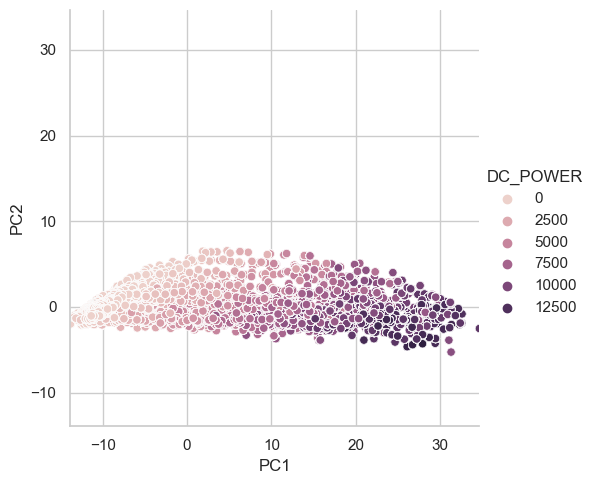

In [35]:

df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df['AC_POWER'] = P1.AC_POWER
df['DC_POWER'] = P1.DC_POWER
df['DAILY_YIELD'] = P1.DAILY_YIELD
df['Total_Yield'] = P1.TOTAL_YIELD
df['HORA'] = P1.HORA


sns.relplot(data = df, x = "PC1", y = "PC2",hue='DC_POWER')
plt.xlim(df["PC1"].min(), df["PC1"].max())
plt.ylim(df["PC1"].min(), df["PC1"].max())
plt.show()

<Axes: xlabel='PC1', ylabel='DC_POWER'>

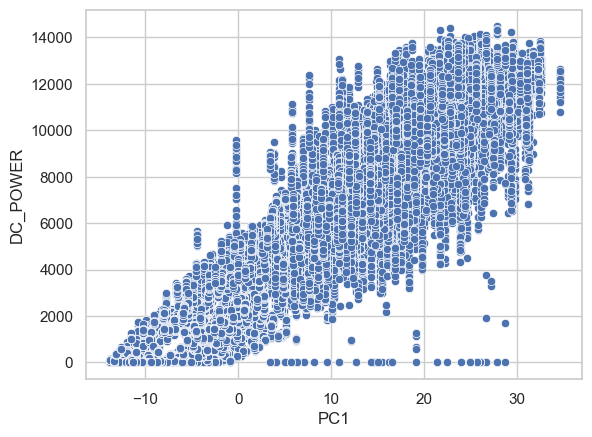

In [36]:

sns.scatterplot(data = df, x = "PC1", y = "DC_POWER")

#### Se observa un aumento de la DC_POWER en la dirección PC1

#### Se ha representado la hora con respecto a PC1 y PC2

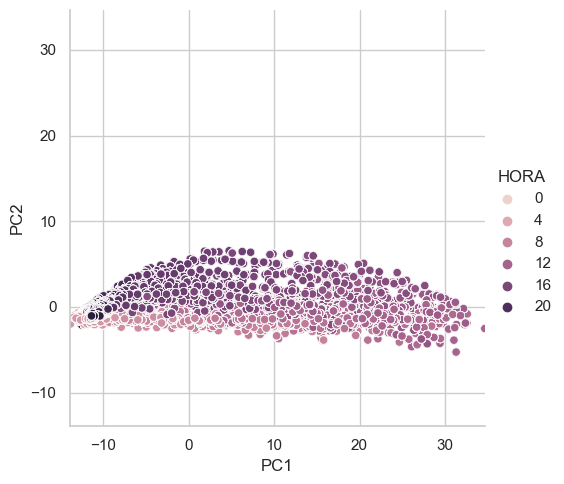

In [37]:



sns.relplot(data = df, x = "PC1", y = "PC2",hue='HORA')
plt.xlim(df["PC1"].min(), df["PC1"].max())
plt.ylim(df["PC1"].min(), df["PC1"].max())
plt.show()

<Axes: xlabel='HORA', ylabel='PC1'>

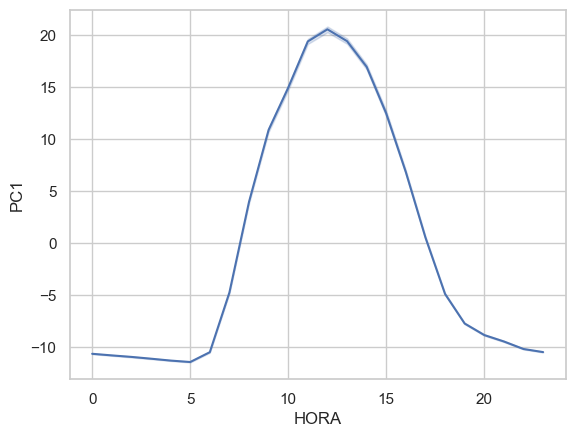

In [38]:
sns.lineplot(data = df, x = "HORA", y = "PC1")

#### Se observa como las graficas son muy parecidas a las a las de irradiación-DC e Irradiación-Hora. Seguramente La PC1 este compuesta mayoritariamente por la irradiación

In [39]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
# Take as many components as needed to explain at least 95% of the variance
d = np.argmax(cumsum >= 0.95) + 1

explained_var_ratio = pca.explained_variance_ratio_

# Imprime las proporciones de varianza explicada
for i, ratio in enumerate(explained_var_ratio):
    print(f'Componente Principal {i+1}: {ratio:.2f}')

# Suma acumulativa de las proporciones de varianza explicada
print(f'Suma acumulativa de varianza explicada: {cumsum}')
print(f'Numero de features seleccionadas: {d}')




Componente Principal 1: 0.98
Componente Principal 2: 0.02
Suma acumulativa de varianza explicada: [0.9823238  0.99997751]
Numero de features seleccionadas: 1


#### Vemos como la componente principal acapara el 98 por cierto de la varianza explicada por lo que se escogerá una única variable para hacer un modelo lineal  

#### Linear regression con una única variable

In [40]:

X_train_scaled =X_train_scaled[:,0].reshape(-1, 1)
X_test_scaled=X_test_scaled[:,0].reshape(-1, 1)

# Crear un modelo de Ridge Regression y ajustarlo a los datos de entrenamiento utilizando cross-validation
lm=LinearRegression()
lm.fit(X_train_scaled, y_train)

# Realizar predicciones en los datos de prueba
y_pred = lm.predict(X_test_scaled)

# Evaluar el modelo utilizando el error cuadrático medio (MSE) y el coeficiente de determinación (R^2)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('El intercepto es '+str(lm.intercept_)+' y el coeficiente es: '+str(lm.coef_))
print('El error Absoluto Medio (KW):', mae)
print('R^2:', r2)



El intercepto es [308.49869997] y el coeficiente es: [[390.4051414]]
El error Absoluto Medio (KW): 26.895415255267526
R^2: 0.9758068225695317


#### Se puede observar como obtenemos prácticamente la misma predicción con una sola variable,simplificando mucho el modelo

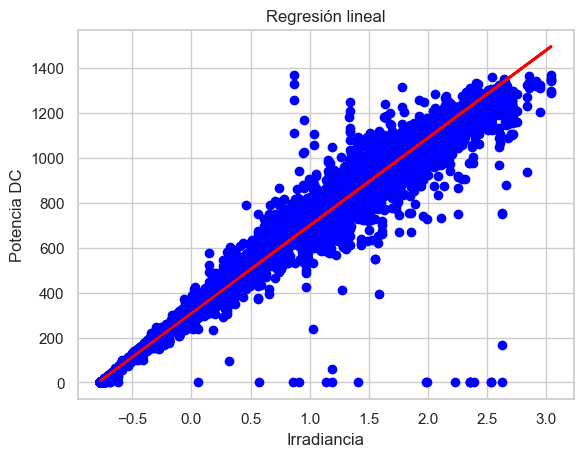

In [41]:
plt.scatter(X_test_scaled, y_test, color='blue')
plt.plot(X_test_scaled, y_pred, color='red', linewidth=2)
plt.title('Regresión lineal')
plt.xlabel('Irradiancia')
plt.ylabel('Potencia DC')
plt.show()

#### Árbol de decisión para predecir la radiación con respecto a las horas del día.

El error Absoluto Medio: 16.57684446477585


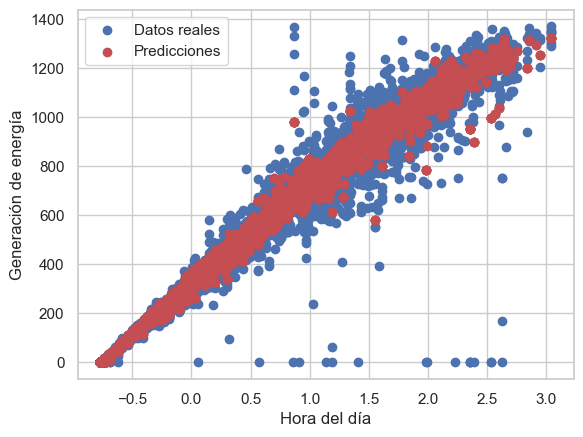

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

model_tree = DecisionTreeRegressor()

model_tree.fit(X_train_scaled, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = model_tree.predict(X_test_scaled)

# Calcula el error cuadrático medio (MSE)
mae = mean_absolute_error(y_test, y_pred)
print(f"El error Absoluto Medio: {mae}")

# Grafica las predicciones
plt.scatter(X_test_scaled, y_test, color='b', label='Datos reales')
plt.scatter(X_test_scaled, y_pred, color='r', label='Predicciones')
plt.xlabel('Hora del día')
plt.ylabel('Generación de energía')
plt.legend()
plt.show()

